# Descarga y exploración del corpus

In [2]:
# Librerias utilizadas

import pandas as pd
import numpy as np
import gzip
import nltk
from nltk.corpus import stopwords
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from gensim.models import Word2Vec
from sklearn.decomposition import PCA
import string
import os
import json
import gzip
from urllib.request import urlopen
from nltk import ngrams
from nltk.probability import FreqDist


In [3]:
# Descargamos 5-core porque cada juguete tiene almenos 5 reviews para poder trabajar
!wget http://snap.stanford.edu/data/amazon/productGraph/categoryFiles/reviews_Toys_and_Games_5.json.gz

--2023-08-01 07:49:16--  http://snap.stanford.edu/data/amazon/productGraph/categoryFiles/reviews_Toys_and_Games_5.json.gz
Resolving snap.stanford.edu (snap.stanford.edu)... 171.64.75.80
Connecting to snap.stanford.edu (snap.stanford.edu)|171.64.75.80|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 42057555 (40M) [application/x-gzip]
Saving to: ‘reviews_Toys_and_Games_5.json.gz’

reviews_Toys_and_Ga 100%[===================>]  40.11M  2.60MB/s    in 17s     

2023-08-01 07:49:36 (2.42 MB/s) - ‘reviews_Toys_and_Games_5.json.gz’ saved [42057555/42057555]



In [4]:
### load the meta data
data = []
with gzip.open('reviews_Toys_and_Games_5.json.gz') as f:
  for l in f:
        data.append(json.loads(l.strip()))

# total length of list, this number equals total number of products
print(len(data))

# first row of the list
print(data[0])

167597
{'reviewerID': 'A1VXOAVRGKGEAK', 'asin': '0439893577', 'reviewerName': 'Angie', 'helpful': [0, 0], 'reviewText': 'I like the item pricing. My granddaughter wanted to mark on it but I wanted it just for the letters.', 'overall': 5.0, 'summary': 'Magnetic board', 'unixReviewTime': 1390953600, 'reviewTime': '01 29, 2014'}


In [5]:
# convert list into pandas dataframe

df = pd.DataFrame.from_dict(data)

print(len(df))

167597


In [6]:
df.head(1).T

,0
reviewerID,A1VXOAVRGKGEAK
asin,0439893577
reviewerName,Angie
helpful,"[0, 0]"
reviewText,I like the item pricing. My granddaughter want...
overall,5.0
summary,Magnetic board
unixReviewTime,1390953600
reviewTime,"01 29, 2014"


In [7]:
# montamos GDrive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [8]:
#  Nos quedamos con las columnas importantes
df = df[['reviewerID', 'summary', 'reviewText', 'overall']]
# Exportar el dataset a un nuevo archivo CSV para facilitar el acceso para la próxima iteración:
df.to_csv('drive/MyDrive/NLP/sampled_data_file.csv', index=False)
# Cargar el dataset:
df = pd.read_csv('drive/MyDrive/NLP/sampled_data_file.csv')

In [9]:
df.head(1).T

,0
reviewerID,A1VXOAVRGKGEAK
summary,Magnetic board
reviewText,I like the item pricing. My granddaughter want...
overall,5.0


In [10]:
# Segun la pagina descargada el reviewText no tenia nulos pero lo comprobamos para poder trabajar corectamente
print(df['reviewText'].isnull().any())
print(df['reviewText'].isna().any())

True
True


Existen review vacios y al guardar y cargar pandas  me crea nan. Para solucionarlo he realizado un guardado y posterior carga antes de hacer la particion para poder eliminar los nan que se crean

In [11]:
df = df.dropna(subset=['reviewText'])

In [12]:
print(df['reviewText'].isnull().any())
print(df['reviewText'].isna().any())

False
False


Para evitar el desequilibrio de clases, muestramos aleatoriamente 4700 muestras para cada uno de los valores. Se elije ese valor porque en una de las clases no hay mas reseñas.

In [13]:
filtered_df = df[df['overall'].isin([1, 2, 3, 4, 5])]
num_samples = 4700

# Muestra el mismo número de filas para cada valor
sampled_df_1 = filtered_df[filtered_df['overall'] == 1].sample(n=num_samples)
sampled_df_2 = filtered_df[filtered_df['overall'] == 2].sample(n=num_samples)
sampled_df_3 = filtered_df[filtered_df['overall'] == 3].sample(n=num_samples)
sampled_df_4 = filtered_df[filtered_df['overall'] == 4].sample(n=num_samples)
sampled_df_5 = filtered_df[filtered_df['overall'] == 5].sample(n=num_samples)

# Concatenar los conjuntos de datos resultantes
result_df = pd.concat([sampled_df_1, sampled_df_2, sampled_df_3, sampled_df_4, sampled_df_5])

In [14]:
# Exportar el dataset a un nuevo archivo CSV para facilitar su uso
result_df.to_csv('drive/MyDrive/NLP/sampled_data_file.csv', index=False)

In [15]:
# Cargar el dataset
df = pd.read_csv('drive/MyDrive/NLP/sampled_data_file.csv')

# Revisar que se cargo bien
df.head()

,reviewerID,summary,reviewText,overall
0,AV4FGV9Q5I7FG,Returned to sender,The helicopter stopped working after 10 minute...,1.0
1,A22B8HUQQYPB1I,child's work disappears after the pen is raised,Here's what's good about the product. It got m...,1.0
2,A94FBTSNO546F,Not the greatest!!,My daughter is 3 and barelt fits on the toy I ...,1.0
3,A2CV9RK6P9IY0,tiny and useless,its too small for long lasting play. if the ch...,1.0
4,A3328AZHVFGA3S,Do not waste your money!,Do not waste your money on this product. Very...,1.0


In [16]:
print(df['reviewText'].apply(type).value_counts()) # Con esto comprobamos que todo sean str y no se hayan quedado ningun NAN

<class 'str'>    23500
Name: reviewText, dtype: int64


# Cardinalidad del vocabulario

In [17]:
# Crea un data frame con solo las reseñas

text_df = df['reviewText']

# Tokenización del texto
nltk.download('punkt')

palabras = []
for review in text_df:
    palabras.extend(nltk.word_tokenize(review.lower()))


# Contar la frecuencia de cada palabra
frecuencia_palabra = {}

for palabra in palabras:
    if palabra not in frecuencia_palabra:
        frecuencia_palabra[palabra] = 1
    else:
        frecuencia_palabra[palabra] += 1

# Ordenar el diccionario por frecuencia
palabras_clasificadas = sorted(frecuencia_palabra.items(), key=lambda x: x[1], reverse=True)

# Calcular la cardinalidad del vocabulario
cardinalidad = len(frecuencia_palabra)

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [18]:
# Mostrar la cardinalidad
print(cardinalidad)

57640


In [19]:
# Ordenar el diccionario por frecuencia
palabras_clasificadas = sorted(frecuencia_palabra.items(), key=lambda x: x[1], reverse=True)

# Las 20 palabras más frecuentes
for word, freq in palabras_clasificadas[:20]:
    print(f"{word}: {freq}")

the: 143041
.: 132262
,: 98124
it: 76600
and: 76104
to: 71675
a: 68119
i: 55002
is: 46933
of: 43496
this: 40519
for: 36804
that: 30809
with: 28218
in: 25843
my: 25669
you: 22755
but: 22662
n't: 20768
not: 20529


In [20]:
# Eliminar palabras vacías y puntuaciones
nltk.download('stopwords')
stopwords = stopwords.words('english')
pontuación = ['.', ',', '!', '(', ')', "''", ':', "``", '...', ';']

palabras_sin_stopwords =  [(palabra, num) for (palabra, num) in palabras_clasificadas if palabra.lower() not in stopwords]
palabras_sin_pontuación = [(palabra, num) for (palabra,num) in palabras_sin_stopwords if palabra.lower() not in pontuación]

# Mostramos otra vez las 20 palabras más frecuentes
for word, freq in palabras_sin_pontuación[:20]:
    print(f"{word}: {freq}")

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


n't: 20768
's: 18376
one: 12067
would: 11242
toy: 11215
like: 10074
game: 9488
get: 8300
play: 7743
old: 7735
little: 7549
really: 7294
fun: 6823
kids: 6579
&: 6000
great: 5815
year: 5679
time: 5606
set: 5438
much: 5394


# N-grams más frecuentes

Realizamos el cálculo de los 2-gramas y 3-grams

In [21]:
bigrams_ = ngrams(palabras_sin_pontuación, 2)
trigrams_ = ngrams(palabras_sin_pontuación, 3)

In [22]:
bigrams_freq_ = FreqDist(bigrams_)
trigrams_freq_ = FreqDist(trigrams_)

In [23]:
bigrams_freq_.most_common(10)

[((("n't", 20768), ("'s", 18376)), 1),
 ((("'s", 18376), ('one', 12067)), 1),
 ((('one', 12067), ('would', 11242)), 1),
 ((('would', 11242), ('toy', 11215)), 1),
 ((('toy', 11215), ('like', 10074)), 1),
 ((('like', 10074), ('game', 9488)), 1),
 ((('game', 9488), ('get', 8300)), 1),
 ((('get', 8300), ('play', 7743)), 1),
 ((('play', 7743), ('old', 7735)), 1),
 ((('old', 7735), ('little', 7549)), 1)]

In [24]:
trigrams_freq_.most_common(10)

[((("n't", 20768), ("'s", 18376), ('one', 12067)), 1),
 ((("'s", 18376), ('one', 12067), ('would', 11242)), 1),
 ((('one', 12067), ('would', 11242), ('toy', 11215)), 1),
 ((('would', 11242), ('toy', 11215), ('like', 10074)), 1),
 ((('toy', 11215), ('like', 10074), ('game', 9488)), 1),
 ((('like', 10074), ('game', 9488), ('get', 8300)), 1),
 ((('game', 9488), ('get', 8300), ('play', 7743)), 1),
 ((('get', 8300), ('play', 7743), ('old', 7735)), 1),
 ((('play', 7743), ('old', 7735), ('little', 7549)), 1),
 ((('old', 7735), ('little', 7549), ('really', 7294)), 1)]

# Distribución de reviews por número de estrellas

In [25]:
# Distribución de reseñas
review_counts = df['overall'].value_counts()
print(review_counts)

1.0    4700
2.0    4700
3.0    4700
4.0    4700
5.0    4700
Name: overall, dtype: int64


Text(0, 0.5, 'Número de reviews')

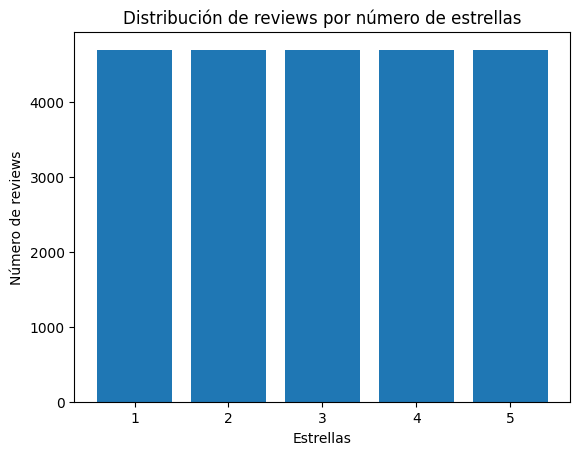

In [26]:
# Visualización de la distribución
fig = plt.figure()
ax = fig.add_subplot(111)
ax.bar(review_counts.index, review_counts.values)

# Texto del grafico
ax.set_title('Distribución de reviews por número de estrellas')
ax.set_xlabel('Estrellas')
ax.set_ylabel('Número de reviews')

# Nº de reviews positivas y negativas

In [27]:
# Cogemos de 1 a 2 como malas críticas y 3 a 5 como buenas
positivas = (df['overall'] >= 3).sum()
negativas = (df['overall'] <= 2).sum()

# Mostar
print(f"Nº de reviews positivas: {positivas}")
print(f"Nº de reviews negativas: {negativas}")

Nº de reviews positivas: 14100
Nº de reviews negativas: 9400


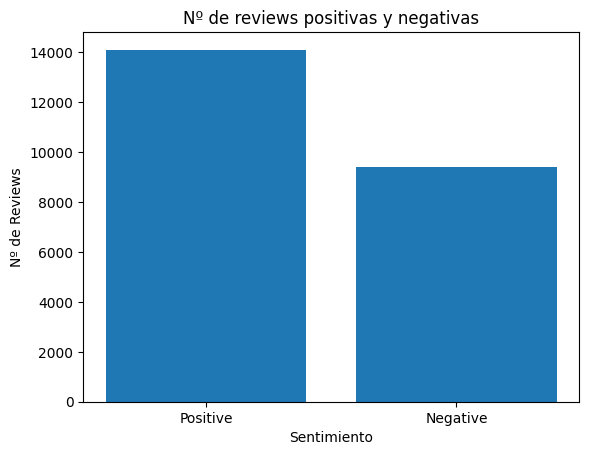

In [28]:
# Visualización
fig = plt.figure()
ax = fig.add_subplot(111)
ax.bar(['Positive', 'Negative'], [positivas, negativas])

# Texto grafico
ax.set_title('Nº de reviews positivas y negativas')
ax.set_xlabel('Sentimiento')
ax.set_ylabel('Nº de Reviews')

plt.show()


# Nubes de palabras







In [29]:
# Uniendo todas las reseñas en una sola cadena
text = ' '.join(df['reviewText'].fillna('').values)

# Crear nube de palabras
nubes = WordCloud(width=800, height=800, background_color='white').generate(text)

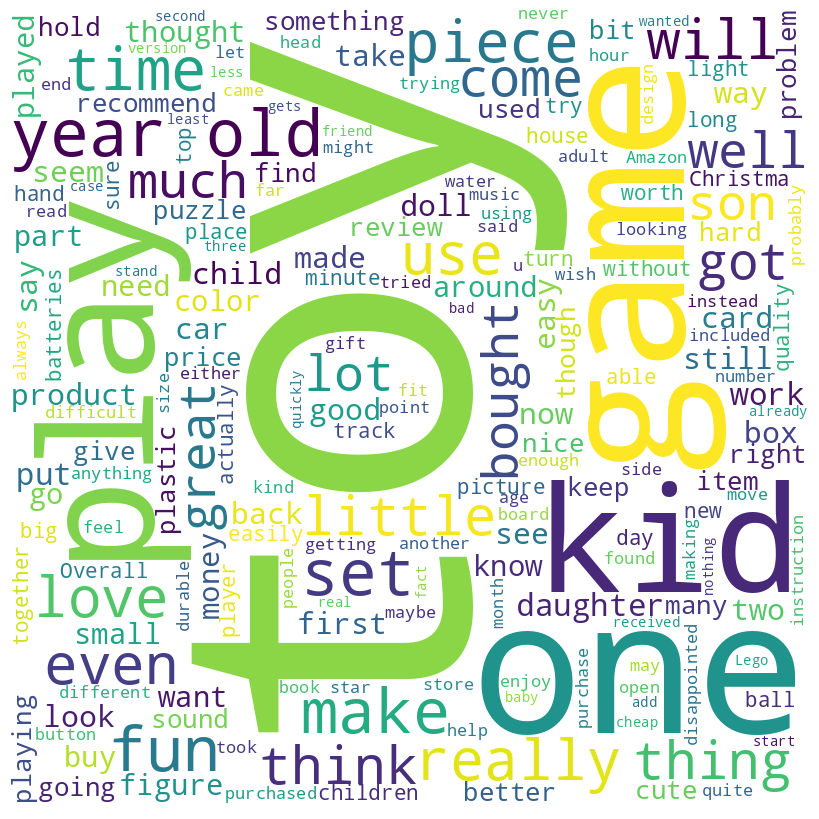

In [30]:
# Visualización
fig = plt.figure(figsize=(8, 8), facecolor=None)
plt.imshow(nubes)
plt.axis('off')
plt.tight_layout(pad=0)
plt.show()

# Word2Vec

Vamos a coger 5 palabras y visualizar las 10 más similares utilizando Word2Vec

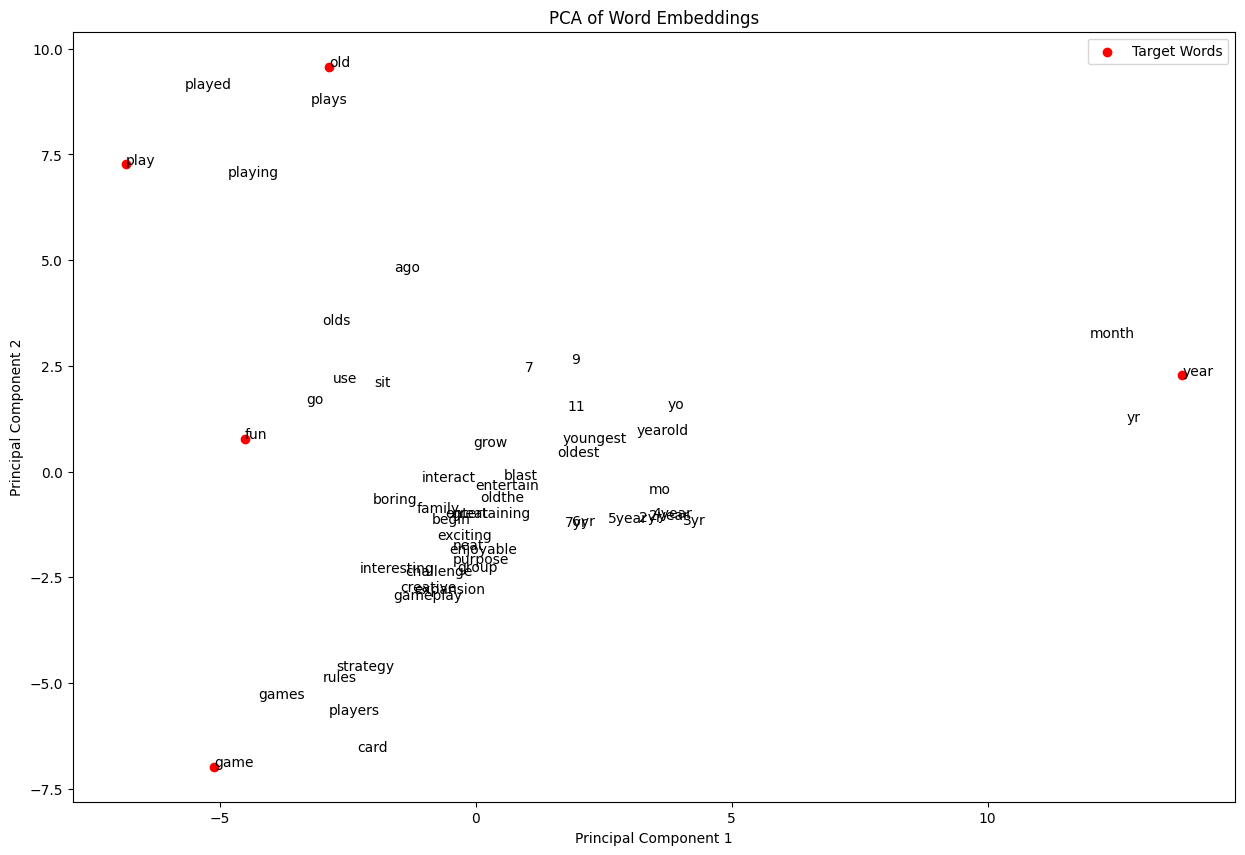

In [32]:
# Uniendo todas las reseñas en una lista
frases = [str(review).lower().split() for review in df['reviewText'].fillna('').values]
frases_clean = []
for frase in frases:
    # Eliminar puntuación
    frase_no_punct = [word.translate(str.maketrans('', '', string.punctuation)) for word in frase]
    frases_clean.append(frase_no_punct)

# Entrenar el modelo de Word2Vec en las oraciones
model = Word2Vec(frases_clean, vector_size =100, window=5, min_count=5, workers=4)

# Eligiendo 5 palabras
palabra_ob = ['game', 'old', 'play', 'fun', 'year']

# Calcular las 10 palabras más similares para cada palabra
similares = {}
for target in palabra_ob:
    similares[target] = [word for word, _ in model.wv.most_similar(target, topn=10)]

# Calcular el PCA de las palabras y sus palabras similares
words = palabra_ob + [word for words in similares.values() for word in words]
embeddings = model.wv[words]
pca = PCA(n_components=2)
principal_components = pca.fit_transform(embeddings)

# Graficar PCA de la palabras
fig, ax = plt.subplots()
ax.scatter(principal_components[:5, 0], principal_components[:5, 1], color='red', label='Target Words')
for i, target in enumerate(palabra_ob):
    ax.annotate(target, (principal_components[i, 0], principal_components[i, 1]))
for i, word in enumerate(words[5:]):
    ax.annotate(word, (principal_components[i+5, 0], principal_components[i+5, 1]))
fig.set_figheight(10)
fig.set_figwidth(15)

# Texto  grafica
ax.set_title('PCA of Word Embeddings')
ax.set_xlabel('Principal Component 1')
ax.set_ylabel('Principal Component 2')
ax.legend()

plt.show()

Mostarmos las 5 palabras y sus 10 similares

In [39]:
model.wv.most_similar('game', topn=10)

[('games', 0.7178780436515808),
 ('gameplay', 0.6426013708114624),
 ('rules', 0.6217601895332336),
 ('expansion', 0.5582948923110962),
 ('family', 0.5548475980758667),
 ('challenge', 0.5494375228881836),
 ('card', 0.5488935112953186),
 ('group', 0.5413752198219299),
 ('players', 0.541191577911377),
 ('strategy', 0.5314640402793884)]

In [34]:
model.wv.most_similar('old', topn=10)

[('olds', 0.8088194131851196),
 ('oldthe', 0.7678141593933105),
 ('ago', 0.6209724545478821),
 ('yo', 0.5638645887374878),
 ('yearold', 0.5609592795372009),
 ('11', 0.5380554795265198),
 ('9', 0.5294737219810486),
 ('oldest', 0.5281344056129456),
 ('7', 0.5248448848724365),
 ('youngest', 0.5221616625785828)]

In [35]:
model.wv.most_similar('year', topn=10)

[('yr', 0.9092901945114136),
 ('month', 0.8385233879089355),
 ('2yr', 0.8263524174690247),
 ('2year', 0.820136547088623),
 ('mo', 0.8150754570960999),
 ('3yr', 0.8128865957260132),
 ('6yr', 0.8093678951263428),
 ('7yr', 0.8088616728782654),
 ('4year', 0.8086633086204529),
 ('5year', 0.8083633780479431)]

In [36]:
model.wv.most_similar('play', topn=10)

[('playing', 0.7404441833496094),
 ('played', 0.6860693097114563),
 ('interact', 0.6365119218826294),
 ('use', 0.5914081931114197),
 ('plays', 0.5864356756210327),
 ('begin', 0.5524725914001465),
 ('sit', 0.52094566822052),
 ('go', 0.5083532929420471),
 ('grow', 0.4930536448955536),
 ('entertain', 0.4865051209926605)]

In [37]:
model.wv.most_similar('fun', topn=10)

[('entertaining', 0.5800623893737793),
 ('blast', 0.5765529870986938),
 ('interesting', 0.5691835284233093),
 ('boring', 0.5198800563812256),
 ('creative', 0.5066447854042053),
 ('great', 0.4935477674007416),
 ('enjoyable', 0.4913553297519684),
 ('exciting', 0.471066415309906),
 ('purpose', 0.46704837679862976),
 ('neat', 0.45440778136253357)]

# Tamaño medio de la reseña

El promedio de palabras por reseña es de 113.56
El número máximo de palabras en una reseña es de 3433
El número mínimo de palabras en una reseña es de 1


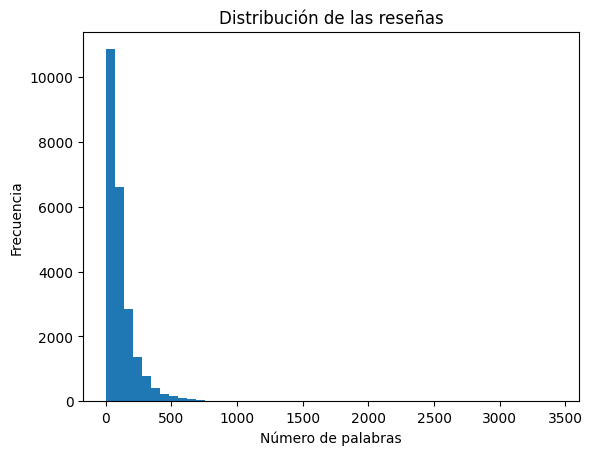

In [42]:
# Contar el número de palabras en un string utilizando una funciona a cada fila de la columna 'reviewText'
def count_words(text):
    return len(text.split())
df['word_count'] = df['reviewText'].apply(count_words)

# Calcule el número promedio, máximo y mínimo
avg_word_count = df['word_count'].mean()
max_word_count = df['word_count'].max()
min_word_count = df['word_count'].min()

# Mostrar
print("El promedio de palabras por reseña es de {:.2f}".format(avg_word_count))
print("El número máximo de palabras en una reseña es de {}".format(max_word_count))
print("El número mínimo de palabras en una reseña es de {}".format(min_word_count))

#Histograma:
plt.hist(df['word_count'], bins=50)

# Texto histograma
plt.xlabel('Número de palabras')
plt.ylabel('Frecuencia')
plt.title('Distribución de las reseñas')
plt.show()

# Conclusiones de la exploración

El dataset analizado es el relacionado con juegos y juguetes de Amazon. El dataset estaba formado por más de 160000 registros. Se ha equilibrado el  corpus segun las diferentes valoraciones y asi balancear las clases.

En muchos conjuntos de datos, especialmente en los de texto, una clase puede estar sobrerepresentada en comparación con las otras y el modelo puede a predecir simplemente la clase más común. Balanceando el modelo podra ser mas preciso.

En el momento de balancear habia una clase que solo tenia 4700 review por suerte la suma de todas las clases es de 23500 y seran datos suficientes para generar el modelo.

Durante la exploracion hemos descubierto las palabras mas utilizadas como por ejemplo:

one,
would,
toy,
like,
game,
get,
old,
play,
little,
really,
fun,
kids,
&,
great,
year,
time,
set,
much

El promedio de palabras por reseña es de 113.84, el número máximo de palabras en una reseña es de 3433 y el número mínimo de palabras en una reseña es de 1. Esto nos puede hacer pensar que las reseñas pueden contener muchos detalles u opiniones que podrían ser útiles para el análisis de opiniones, pero a la vez tambien tenemos que tener en cuenta que podría significar que algunas de las reseñas son demasiado repetitivas.

En general, las reseñas estan equilibradas pero al incluir que las valoraciones a partir de 3 estrellas son datos positivos. En el corpus podemos distingir  14100 datos positivos y 9400 negativos.

Al utilizar Word2Vec para la similutid de palabras encontré que la palabra "game" es similar a 'games', gameplay' pero me sorprendio que con un 60% es similar a las palabras 'rules' y'monopoly', mientras que la palabra "old" es más similar a 'olds', 'oldthe'.
La palabra 'fun' tiene relacion con 'entertaining', 'great', 'entertainment', Curiosamente, la palabra 'year' su similitud  es con sus abrevaciones de year  como  'yr', '2yr', '3yr' o '4year'

Los resultados del análisis de Word2Vec sugieren que algunas palabras que podrían considerarse opuestas, como "fun" y "boring", en realidad se usan en contextos similares en estas reseñas. Esto podría deberse a la naturaleza subjetiva de las reseñas, en las que un  juego divertido para una persona puede no ser necesariamente la misma para otra.